## Fetal Health - Model Building

In [484]:
import pandas as pd
import numpy as np
import optuna

from scipy import stats
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, recall_score
import xgboost as xgb

#xgb_cl = xgb.XGBClassifier()

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings('ignore')

In [311]:
df = pd.read_csv("Documents/FetalHealthClassification/fetal_health.csv")

In [312]:
df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [313]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

We know that we don't have any null values, so we don't have to worry about doing any missing value imputation.

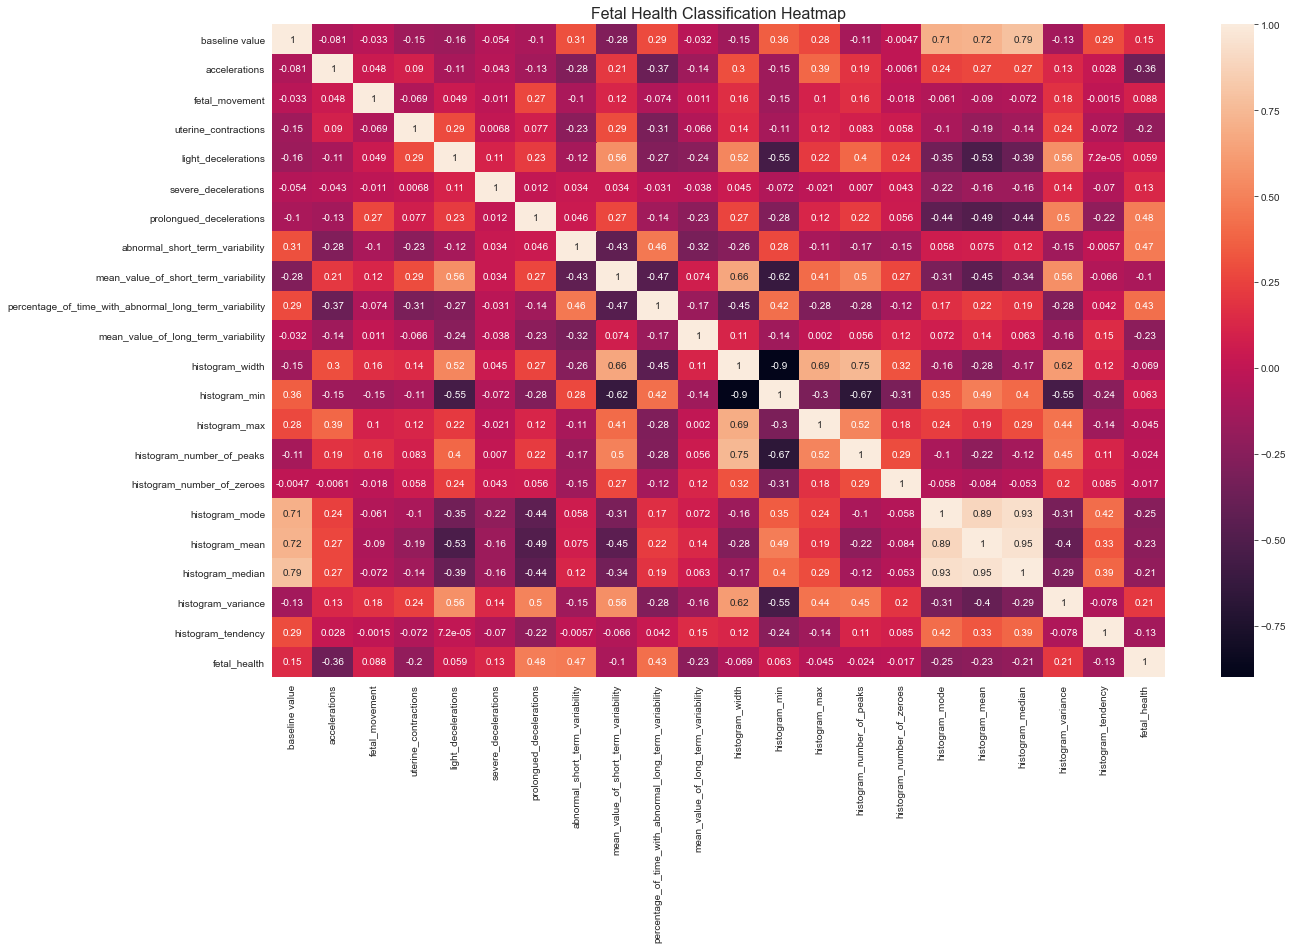

In [314]:
plt.figure(figsize=(20, 12)) 
plt.title('Fetal Health Classification Heatmap', fontsize=16)
heatmap = sns.heatmap(df.corr(), annot=True)

As we noticed in the EDA, the metrics of the exams are correlated. Since we'll perform LDA, we may be able to phase out these correlations that way. I'll also print each attribute's distribution in order to make a better decision on how to impute outliers.

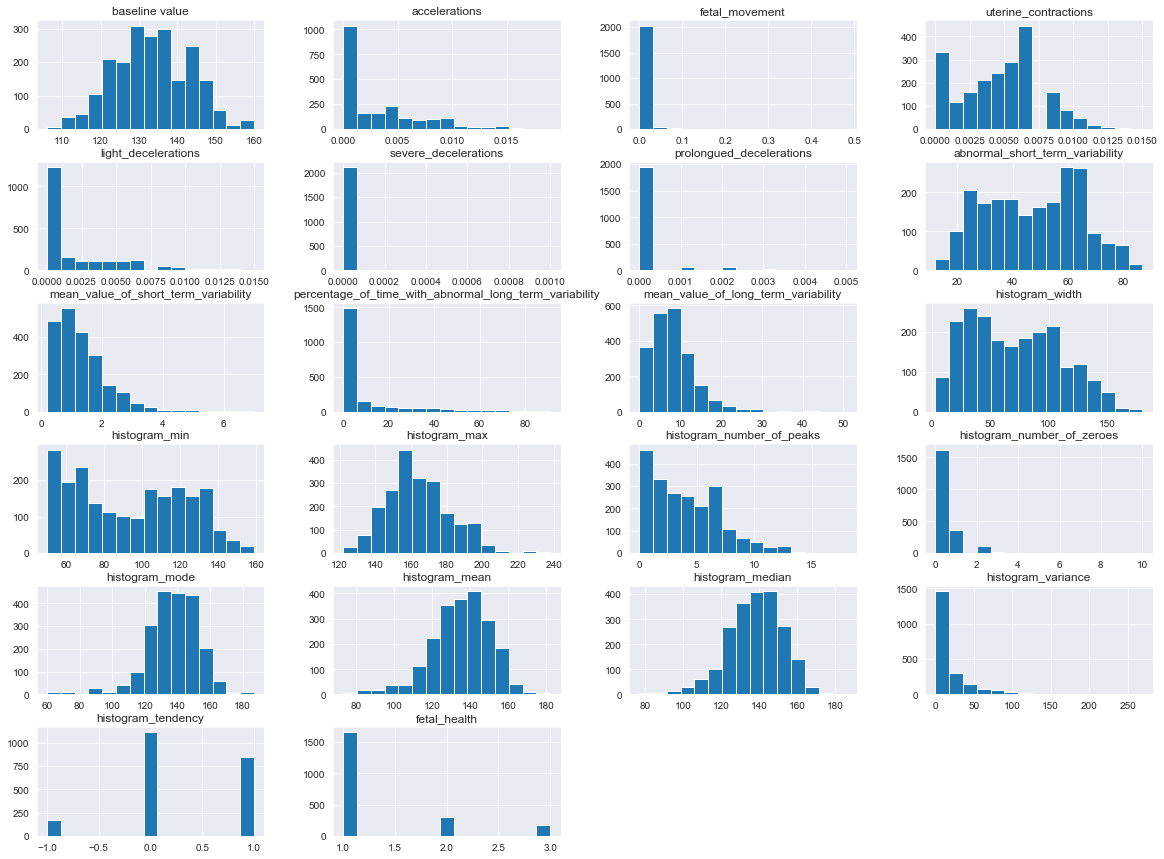

In [315]:
df.hist(bins=15, figsize=(20, 15), layout=(6, 4));

I want to print the current class distributions here again so that we can easily see the class imbalance as we move into outlier detection and potentially clustering. We saw from the box plots from EDA that there are some extremel outliers among some of the attributes. 

Since we are dealing with attributes of different scales measuring different elements of the cardiotocography exams. I will impute missing values with <b>IQR capping.</b>

In [316]:
df['fetal_health'].value_counts() #target value distributions

1.0    1655
2.0     295
3.0     176
Name: fetal_health, dtype: int64

## Outlier Detection

We'll see what the data looks like after computing the IQR and capping/trimming the columns within the IQR.

In [317]:
iqr_cols = df.columns.tolist()[:-1] #all columns except the target

new_df = df.copy()

In [318]:
'''IQR'''
for col in iqr_cols:
    p_25 = new_df[col].quantile(0.25)
    p_75 = new_df[col].quantile(0.75)
    iqr = p_75 - p_25
    
    upper_limit = p_75 + (1.5 * iqr)
    lower_limit = p_25 + (1.5 * iqr)
    
    #Trimming Strategy:
    new_df.loc[new_df[col] > upper_limit, col] = upper_limit
    new_df.loc[new_df[col] < lower_limit, col] = lower_limit
    
    
    #Capping Strategy:
    #new_df[col] = np.where(
            #new_df[col] > upper_limit, upper_limit,
            #np.where(
                #new_df[col] < lower_limit, lower_limit, new_df[col] ))
    

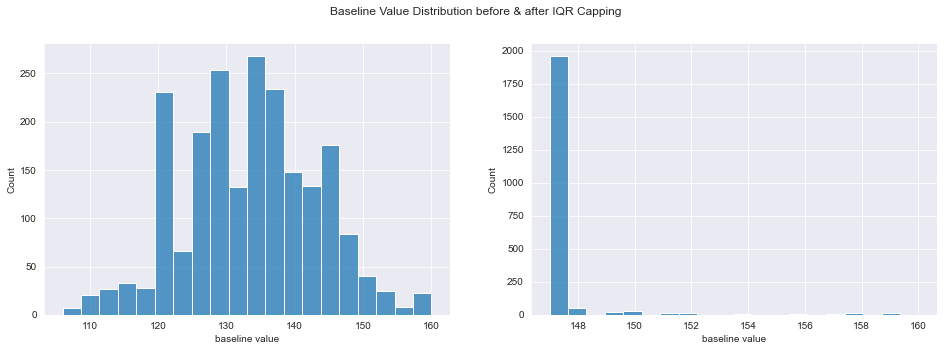

In [319]:
fig, axes = plt.subplots(1, 2, figsize=(16,5))
plt.suptitle('Baseline Value Distribution before & after IQR Capping')
sns.histplot(x='baseline value', data=df, bins=20, ax=axes[0])
sns.histplot(x='baseline value', data=new_df, bins=20, ax=axes[1])
plt.show()

It seems that even when binning the data with 20 bins after capping, most of the values in the heartrate baseline data gets shoved into a small range of values. For now let's continue while leaving the data alone. It is possible to also employ a clustering method to detect outliers.

## PCA Application

First, we're going to use PCA as a form of anomoly detection, I learned how to use it in this manner from: https://www.kaggle.com/code/ryanholbrook/principal-component-analysis

In [320]:
X = df.loc[:, :'histogram_tendency']
y = df.loc[:, 'fetal_health']

In [321]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [322]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

comp_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=comp_names)

X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21
0,-0.263977,-2.568375,1.302902,1.826119,0.379183,-0.326087,-2.254560,-0.533575,0.252293,0.456495,0.232581,1.324954,1.761394,1.017870,0.589256,0.774131,-0.312384,0.849963,0.788461,-0.667488,4.173733e-15
1,1.954458,2.230317,-1.090115,-0.501233,-0.226035,0.672451,0.793729,-0.555810,0.236623,-0.550629,0.012450,0.275320,-0.454686,-0.001353,-1.183237,0.143357,0.090477,-0.158248,-0.089932,0.013280,6.918762e-16
2,1.971485,1.968333,-1.286533,-0.210096,-0.554692,0.411061,1.554747,-0.145268,-0.204309,-0.554284,-0.247613,0.291970,-0.262157,0.052347,-1.381607,0.323515,0.014106,-0.138219,-0.097598,-0.052837,-2.114701e-15
3,2.222056,2.134027,-2.190836,1.601091,-0.046659,-0.428954,0.507563,0.390144,-1.804148,-0.229709,-0.698648,0.922679,-1.090830,-0.292555,0.297691,-0.737588,0.381569,0.078602,-0.067854,-0.000435,-9.668045e-16
4,1.785438,2.190154,-2.508413,0.740641,0.267545,-0.259766,-0.109299,0.243573,-1.238910,0.326136,-0.812357,1.224144,-0.602461,-0.649632,-0.027533,-0.434136,0.431303,0.309926,-0.182709,-0.005295,5.954752e-15


In [323]:
loadings = pd.DataFrame(pca.components_.T, columns = comp_names, index=X.columns)

In [324]:
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21
baseline value,-0.224146,0.277316,0.340075,0.059543,-0.082006,-0.025722,0.245071,0.188533,-0.096493,0.076864,0.185264,-0.118278,-0.103545,-0.125228,-0.074902,-0.230237,0.356729,0.476780,-0.373269,-0.090603,2.079181e-16
accelerations,0.043423,0.278637,-0.186841,-0.435785,0.105234,0.107714,-0.430843,-0.118178,0.265039,0.144963,-0.057246,0.097971,0.213377,-0.136590,0.038484,-0.503959,0.130019,-0.046966,-0.174541,-0.006017,-1.472818e-17
fetal_movement,0.080645,0.038425,0.101702,-0.004773,0.633875,-0.180036,0.024939,0.483888,0.253602,-0.382747,-0.242058,-0.172715,0.108473,-0.018144,-0.001924,0.024781,0.019005,0.018362,0.000223,-0.005570,-5.759704e-17
uterine_contractions,0.127398,0.027192,-0.120827,-0.297931,-0.461380,-0.342192,0.229474,0.283271,-0.091140,0.036102,-0.605880,0.154893,0.029581,-0.046487,-0.085619,-0.035059,0.004533,0.064248,0.019002,-0.001791,-1.983878e-17
light_decelerations,0.278643,0.020613,0.200836,0.077951,-0.354253,-0.178518,-0.039833,0.087116,-0.006542,-0.393634,0.277459,-0.285989,-0.016840,0.167962,-0.049300,-0.501766,-0.039405,-0.294414,0.155750,-0.005808,6.729483e-17
severe_decelerations,0.057744,-0.078264,0.071130,0.036292,-0.200270,0.706669,-0.202920,0.599790,-0.029138,0.045502,-0.045973,0.064644,-0.125204,-0.077274,-0.026503,0.003766,-0.091379,-0.059624,0.016363,0.000805,-1.474690e-17
prolongued_decelerations,0.202817,-0.113615,0.336746,-0.096371,0.282724,-0.160034,0.212827,0.107634,0.016367,0.606222,0.103005,0.131565,-0.239251,-0.138857,-0.150192,-0.227120,-0.171910,-0.237549,0.164485,0.038139,-4.792069e-17
abnormal_short_term_variability,-0.145518,-0.122293,0.491748,0.092521,-0.052418,0.086371,-0.144734,-0.206992,-0.159134,0.125865,-0.407620,-0.399723,0.367933,-0.248794,0.229704,-0.045411,-0.103371,-0.051548,0.067321,-0.049186,-4.634411e-17
mean_value_of_short_term_variability,0.316295,0.135011,-0.074591,-0.042994,-0.070535,-0.050096,0.104430,0.012101,-0.031314,-0.177987,0.281170,0.088830,0.083158,-0.784203,0.247124,0.171621,-0.063804,0.054656,0.118152,-0.052357,-5.616396e-17
percentage_of_time_with_abnormal_long_term_variability,-0.217062,-0.140811,0.320633,0.212111,0.005961,0.026171,0.007022,-0.136872,0.068000,-0.342611,-0.100068,0.720238,0.125015,-0.134991,-0.195465,-0.193264,-0.004152,-0.070608,-0.012144,0.020842,7.948964e-17


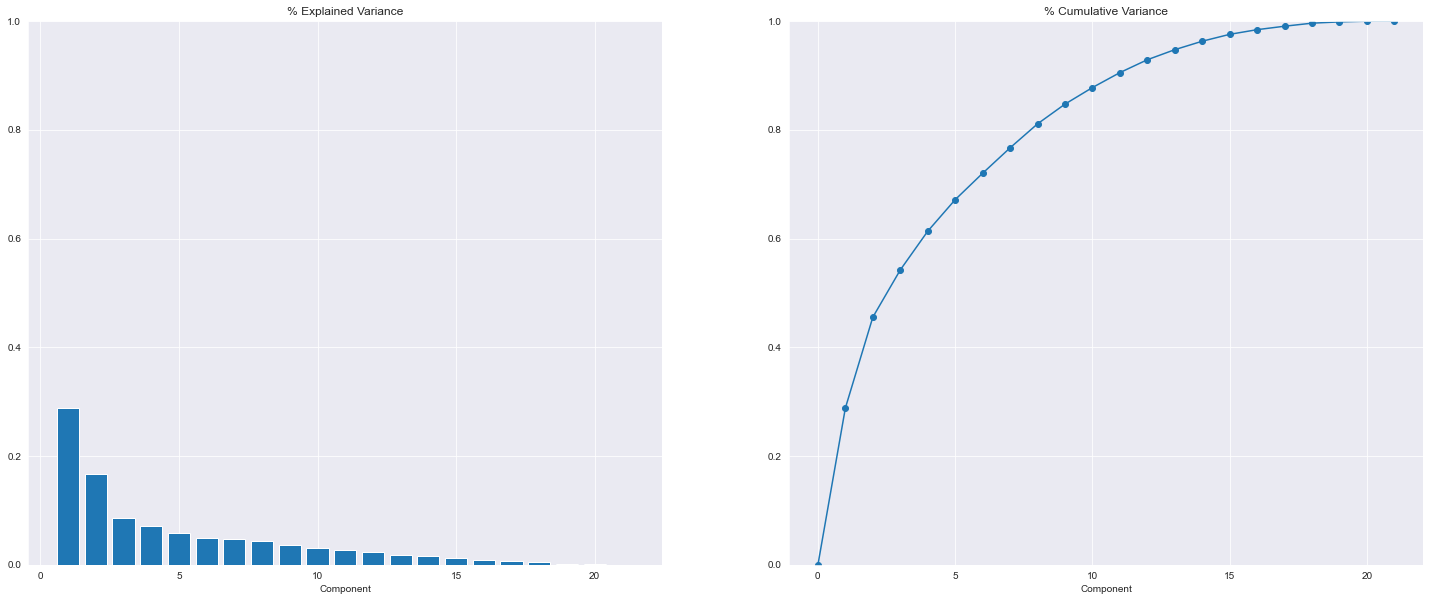

In [325]:
fig, axs = plt.subplots(1, 2, figsize=(25,10))
n = pca.n_components_
grid = np.arange(1, n + 1)

evr = pca.explained_variance_ratio_
axs[0].bar(grid, evr)
axs[0].set(
    xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
)

cv = np.cumsum(evr)
axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
axs[1].set(
    xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
)

plt.show()

It appears 8 principal components explain at least 80% of the variation within the data. Let's re-run PCA except with 8 components.

In [326]:
pca = PCA(n_components=8)
X_pca = pca.fit_transform(X_scaled)

comp_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=comp_names)

X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,-0.263977,-2.568375,1.302902,1.826118,0.379184,-0.326086,-2.254557,-0.533576
1,1.954458,2.230317,-1.090115,-0.501233,-0.226035,0.672451,0.793729,-0.555810
2,1.971485,1.968333,-1.286533,-0.210096,-0.554692,0.411061,1.554746,-0.145267
3,2.222056,2.134027,-2.190836,1.601091,-0.046659,-0.428954,0.507563,0.390145
4,1.785438,2.190154,-2.508413,0.740641,0.267544,-0.259767,-0.109299,0.243574


In [327]:
loadings = pd.DataFrame(pca.components_.T, columns = comp_names, index=X.columns)

In [328]:
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
baseline value,-0.224146,0.277316,0.340075,0.059543,-0.082006,-0.025722,0.245071,0.188533
accelerations,0.043423,0.278637,-0.186841,-0.435785,0.105234,0.107714,-0.430843,-0.118178
fetal_movement,0.080645,0.038425,0.101702,-0.004773,0.633875,-0.180036,0.024939,0.483888
uterine_contractions,0.127398,0.027192,-0.120827,-0.297931,-0.461380,-0.342192,0.229474,0.283271
light_decelerations,0.278643,0.020613,0.200836,0.077951,-0.354253,-0.178518,-0.039832,0.087116
severe_decelerations,0.057744,-0.078264,0.071130,0.036292,-0.200270,0.706669,-0.202920,0.599790
prolongued_decelerations,0.202817,-0.113615,0.336746,-0.096371,0.282724,-0.160034,0.212827,0.107634
abnormal_short_term_variability,-0.145518,-0.122293,0.491748,0.092521,-0.052418,0.086371,-0.144734,-0.206992
mean_value_of_short_term_variability,0.316295,0.135011,-0.074591,-0.042994,-0.070535,-0.050096,0.104430,0.012101
percentage_of_time_with_abnormal_long_term_variability,-0.217062,-0.140811,0.320633,0.212111,0.005961,0.026171,0.007022,-0.136872


In [329]:
data_pca = pd.DataFrame(data = pca.components_,
                           columns = X.columns.values,
                           index = ['Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5', 'Component 6', 'Component 7', 'Component 8'])
data_pca

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency
Component 1,-0.224146,0.043423,0.080645,0.127398,0.278643,0.057744,0.202817,-0.145518,0.316295,-0.217062,-0.008054,0.313552,-0.332077,0.133658,0.251140,0.123175,-0.262567,-0.308815,-0.276006,0.290681,-0.070344
Component 2,0.277316,0.278637,0.038425,0.027192,0.020613,-0.078264,-0.113615,-0.122293,0.135011,-0.140811,0.096376,0.282859,-0.142433,0.379433,0.239990,0.127097,0.367239,0.325682,0.376158,0.100138,0.225862
Component 3,0.340075,-0.186841,0.101702,-0.120827,0.200836,0.071130,0.336746,0.491748,-0.074591,0.320633,-0.432172,0.063889,0.029083,0.186609,0.107529,-0.003772,0.023271,-0.022153,0.065643,0.265596,-0.039212
Component 4,0.059543,-0.435785,-0.004773,-0.297931,0.077951,0.036292,-0.096371,0.092521,-0.042994,0.212111,0.378401,0.105237,-0.282824,-0.237444,0.157216,0.295637,-0.017329,-0.052817,-0.043112,-0.095268,0.478441
Component 5,-0.082006,0.105234,0.633875,-0.461380,-0.354253,-0.200270,0.282724,-0.052418,-0.070535,0.005961,0.191269,0.058189,-0.038146,0.063485,0.098754,-0.202983,-0.044294,0.020514,-0.039151,-0.028194,-0.114535
Component 6,-0.025722,0.107714,-0.180036,-0.342192,-0.178518,0.706669,-0.160034,0.086371,-0.050096,0.026171,0.163257,0.087659,0.030352,0.240301,0.066610,0.183147,-0.108505,0.044801,-0.010489,-0.023351,-0.353970
Component 7,0.245071,-0.430843,0.024939,0.229474,-0.039832,-0.202920,0.212827,-0.144734,0.104430,0.007022,0.399557,-0.081663,0.239365,0.217030,-0.082070,0.361835,0.003393,0.039146,0.018816,0.048598,-0.410415
Component 8,0.188533,-0.118178,0.483888,0.283271,0.087116,0.599790,0.107634,-0.206992,0.012101,-0.136872,0.063598,-0.124002,0.065833,-0.160752,-0.201689,-0.130754,0.057987,0.047716,0.065066,0.144918,0.239175


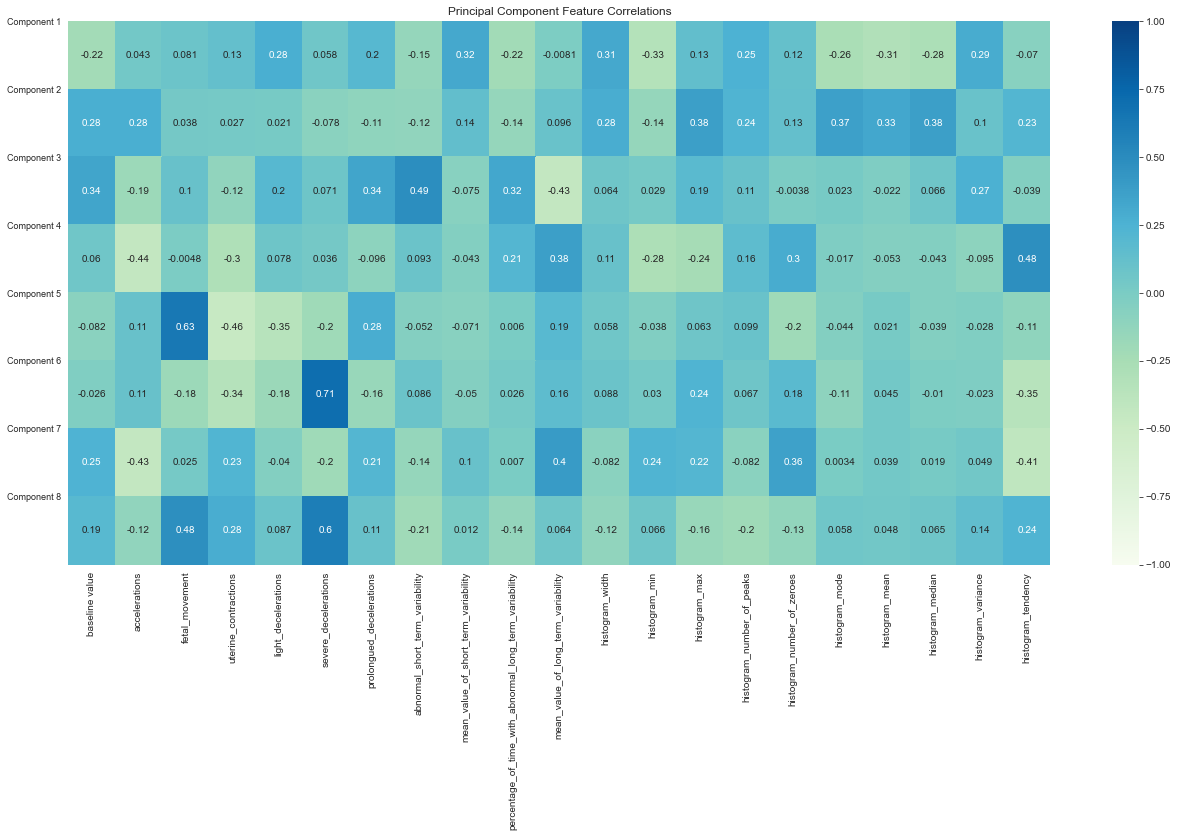

In [330]:
plt.figure(figsize=(22,10))
sns.heatmap(data_pca, vmin=-1, vmax=1, cmap='GnBu', annot=True)
plt.title('Principal Component Feature Correlations')
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7], ['Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5', 'Component 6', 'Component 7', 'Component 8'],rotation=0, fontsize=9)
plt.show()

Now I'll look at some of the lpca components within the data and look at differences.

In [331]:
component = "PC3"

idx = X_pca[component].sort_values(ascending=False).index
df.loc[idx, ["baseline value", "accelerations", "fetal_movement", 'uterine_contractions', 'light_decelerations', 'severe_decelerations', 'prolongued_decelerations', 'fetal_health']]

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,fetal_health
1908,130.0,0.002,0.002,0.008,0.008,0.0,0.002,3.0
1907,130.0,0.002,0.002,0.009,0.009,0.0,0.002,3.0
1909,130.0,0.002,0.002,0.008,0.008,0.0,0.002,3.0
704,130.0,0.000,0.353,0.000,0.000,0.0,0.005,3.0
1755,134.0,0.003,0.000,0.000,0.000,0.0,0.005,3.0
...,...,...,...,...,...,...,...,...
1280,112.0,0.005,0.000,0.007,0.002,0.0,0.000,1.0
681,140.0,0.003,0.003,0.004,0.000,0.0,0.000,1.0
617,142.0,0.000,0.001,0.002,0.000,0.0,0.000,1.0
166,134.0,0.003,0.007,0.001,0.000,0.0,0.000,1.0


Looking at PC3 (since PC3 had the highest value for prolonged decelerations), we can see it found some differences with the pathological records being together on top. We have further confirmation that pathological records have more prolonged decelerations and the baseline heartrate falls within a certain range, which are a few things we found in our EDA.

PC1 had the highest value for light decelerations

In [332]:
component = "PC1"

idx = X_pca[component].sort_values(ascending=False).index
df.loc[idx, ["baseline value", "accelerations", "fetal_movement", 'uterine_contractions', 'light_decelerations', 'severe_decelerations', 'prolongued_decelerations', 'fetal_health']]

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,fetal_health
6,134.0,0.001,0.000,0.013,0.008,0.0,0.003,3.0
661,128.0,0.000,0.000,0.006,0.014,0.0,0.003,2.0
5,134.0,0.001,0.000,0.010,0.009,0.0,0.002,3.0
682,132.0,0.000,0.306,0.004,0.004,0.0,0.004,3.0
1908,130.0,0.002,0.002,0.008,0.008,0.0,0.002,3.0
...,...,...,...,...,...,...,...,...
126,159.0,0.000,0.000,0.004,0.000,0.0,0.000,2.0
402,151.0,0.000,0.000,0.000,0.000,0.0,0.000,2.0
821,152.0,0.000,0.000,0.004,0.000,0.0,0.000,2.0
130,158.0,0.000,0.000,0.000,0.000,0.0,0.000,1.0


We can see here that pathological and some suspect records have lower baseline heartrate and in this component, we have higher light decelerations along with uterine contractions in addition to prolonged decelerations, while normal and some suspect records have no prolonged decelerations.

I've noticed that fetal movement has a few outlying records in the above two component data frames. This perhaps is the kind of outlier we can expect within the data, but since we have only so much data, they may be important to us.

PC2 seems to have high values for the cardiotocography exam metrics, lets look at that next.

In [333]:
component = "PC2"

idx = X_pca[component].sort_values(ascending=False).index
df.loc[idx, ['baseline value', "histogram_width", "histogram_min", "histogram_max", 'histogram_number_of_peaks', 'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean', 'histogram_median', 'histogram_variance', 'histogram_tendency', 'fetal_health']]

,baseline value,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
141,154.0,147.0,50.0,197.0,10.0,10.0,153.0,158.0,162.0,27.0,1.0,1.0
526,142.0,148.0,51.0,199.0,12.0,0.0,180.0,164.0,171.0,53.0,1.0,1.0
181,138.0,148.0,52.0,200.0,11.0,2.0,146.0,157.0,161.0,72.0,1.0,1.0
438,151.0,149.0,51.0,200.0,12.0,8.0,156.0,150.0,157.0,56.0,1.0,2.0
552,136.0,148.0,52.0,200.0,11.0,2.0,146.0,159.0,162.0,74.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1791,121.0,105.0,55.0,160.0,7.0,0.0,67.0,85.0,92.0,109.0,-1.0,3.0
1793,121.0,102.0,55.0,157.0,5.0,1.0,67.0,83.0,90.0,98.0,-1.0,3.0
1792,121.0,102.0,55.0,157.0,4.0,1.0,67.0,81.0,87.0,89.0,-1.0,3.0
1795,121.0,102.0,55.0,157.0,6.0,2.0,67.0,76.0,79.0,68.0,-1.0,3.0


The exam graph tendency for normal records indicates a positive trend, while for pathological records a negative trend. I also included baseline heartrate here as well. 

It seems pathological records have a trace of lower baseline heartrates and a shorter exam graph. Pathological records also have lower mean, mode, and median values in their graphs and consistent patterns between those and normal records. Again, we noticed this in our EDA, and our PCA analysis here backs it up!

Since the anomolies I noticed may be important to retain, I'll choose to keep them.

## KMeans Feature Application

Could we develop clustering of the 3 classes of our target variable using KMeans?

In [334]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [335]:
wcss=[]

for i in range(1,10):
    kmeans=KMeans(i, init='k-means++')
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
wcss

[44645.99999999991,
 36342.14984022764,
 32389.029370542656,
 29000.898252375606,
 27212.47259236716,
 25033.531745829,
 23313.71290333151,
 22022.89181155115,
 21006.217017344545]

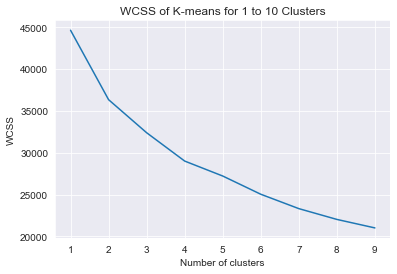

In [336]:
plt.plot(range(1,10),wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title("WCSS of K-means for 1 to 10 Clusters")
plt.show()

In [337]:
kmeans_new=KMeans(3, init='k-means++')
kmeans_new.fit(X_scaled)
clusters_new=X.copy()
clusters_new['cluster_pred']=kmeans_new.fit_predict(X_scaled)

In [338]:
class_compare = pd.concat([clusters_new['cluster_pred'], y], axis=1)

In [339]:
class_compare

,cluster_pred,fetal_health
0,2,2.0
1,1,1.0
2,1,1.0
3,1,1.0
4,1,1.0
...,...,...
2121,2,2.0
2122,2,2.0
2123,2,2.0
2124,2,2.0


In [340]:
len(np.where(class_compare['cluster_pred']==class_compare['fetal_health'])[0])

1282

We can try to plot these KMeans cluster features and see how well they go with the data. Then, if they can be used reliably as features, we could include these clusters in our data.

In [341]:
features = ['baseline value', 'accelerations', 'fetal_movement', 'uterine_contractions', 'light_decelerations', 'severe_decelerations', 'prolongued_decelerations']

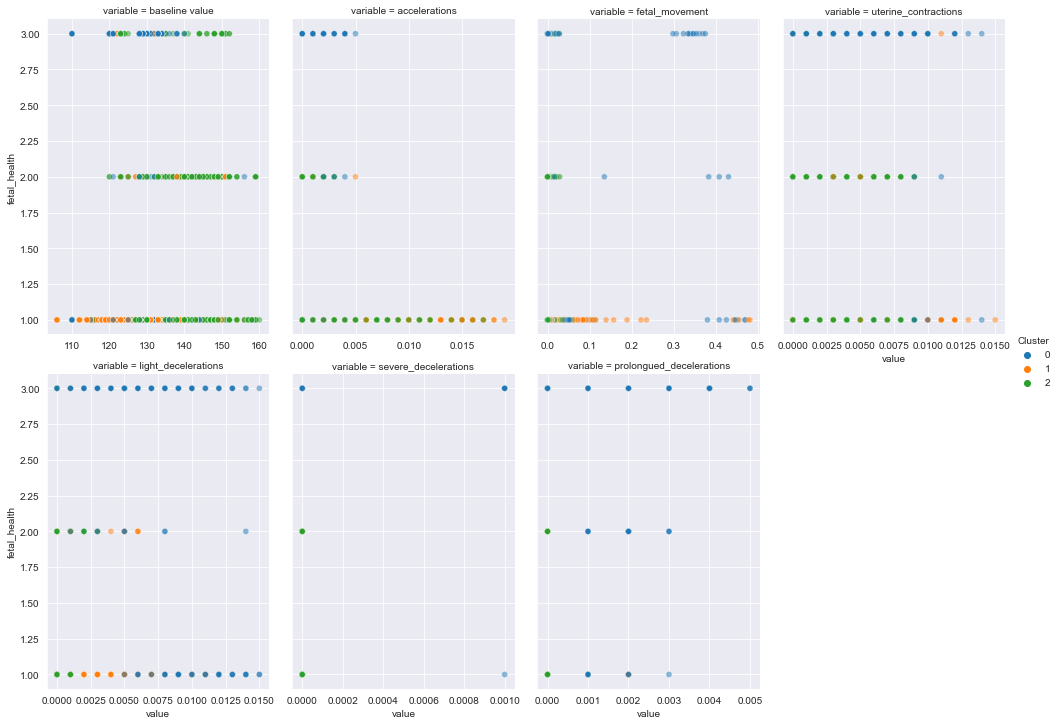

In [342]:
X_clus = X.copy()
X_clus["Cluster"] = class_compare.cluster_pred.astype("category")
X_clus["fetal_health"] = y
sns.relplot(
    x="value", y="fetal_health", hue="Cluster", col="variable", alpha=0.5,
    height=5, aspect=0.7, facet_kws={'sharex': False}, col_wrap=4,
    data=X_clus.melt(
        value_vars=features, id_vars=["fetal_health", "Cluster"],
    ),
);

We can see some separation between the clusters when plotting with these select features, we can try to model with and without these cluster features and see how model performance is impacted.

In [404]:
#COMMENT OUT if you wish not to use the cluster feature
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
#lbl.fit_transform(class_compare['cluster_pred'].astype(str))
X['kmeans_cluster'] = lbl.fit_transform(class_compare['cluster_pred'].astype(str)) #model does slightly better WITH this feature

#try object if category becomes an issue

## LDA Application

Now that we've seen what values and attributes best separate the data, lets now conduct LDA on the classes in question (fetal_health) and see if they are split in a similar manner.

Since we have 3 classes, we can use LDA to split the classes into 2 linear discriminants.

Helpful blog on implementation: https://www.mygreatlearning.com/blog/linear-discriminant-analysis-or-lda/

In [405]:
lda = LDA(n_components=2)

In [406]:
X_lda = lda.fit_transform(X, y)

In [407]:
lda.explained_variance_ratio_

#before adding kmeans: array([0.8035912, 0.1964088])

array([0.80558485, 0.19441515])

In [408]:
X_lda[:,0]

array([ 1.79460048, -1.75314949, -1.74394584, ...,  0.28030625,
        0.65936482,  1.13817967])

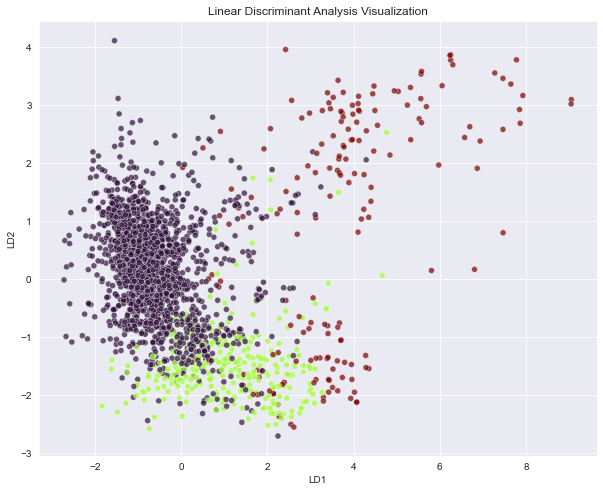

In [409]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=X_lda[:,0], y=X_lda[:,1], c=y, cmap='turbo', alpha=0.7, edgecolors='black')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title('Linear Discriminant Analysis Visualization')
plt.show()

In [410]:
X_lda.shape

(2126, 2)

Now we can try to build a model using these LDA components that conveniently resulted in 2-dimensions for us to plot above.

In [411]:
X.head() #you apply scaler AFTER calling train_test_split!!

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,kmeans_cluster
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1


## Model Building
We can try to build models using X_lda, our regular X dataset, (or maybe combine both?)

We can try to make a case for choosing particular models:

* SVM: We want to try to separate our classes (target being fetal_health) as best we can, therefore this model is a rational choice.


* KnearestNeighbors: Since the class splits have been separable based on distance for many attributes.


* Random Forest Classifier: There are many thresholds in the data where there is a clear distinction what the dominant group is in a given attribute's array of values.


* AdaBoost, XGBoost and CatBoost: More powerful tree-based algorithms.

In [412]:
#Run if we want both X w/ X_lda
X_all = pd.concat([X, pd.DataFrame(X_lda, columns=['LD1', 'LD2'])], axis=1)
X_all.head() #So it could have X, kmeans, and LDA info.

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,kmeans_cluster,LD1,LD2
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2,1.794600,-1.338490
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1,-1.753149,0.504693
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1,-1.743946,0.274833
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1,-1.771478,0.430695
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1,-1.839874,1.148278


In [413]:
X.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,kmeans_cluster
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1


In [518]:
#We use stratify set to y since the classes are imbalanced in this data.
#Sub out X_all for X_lda or X depending on what you want to test.

#X_all > X_lda, where X_all contains X_lda
#X_all > X where X also has the clusters.

X_train, X_test, y_train, y_test  = train_test_split(X_all, y, test_size=0.25, random_state=3) #, stratify=y) 

In [519]:
mm_scaler = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train_svm = mm_scaler.transform(X_train)
#X_test_svm = mm_scaler.transform(X_test)

Since we are trying to separate classes here as a priority, we're going to try SVM with GridSearchCV. Since SVM requires values to be between -1 and 1, we'll use MinMaxScaler for this algorithm.

<b>Support Vector Machine:</b>

In [520]:
param_grid = {'C': [1, 2, 5, 10, 20], 'kernel': ('rbf', 'sigmoid')}

svm = SVC(random_state=3, max_iter=-1)

clf = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1)
clf.fit(X_train_svm, y_train)

print('GridSearch Best Estimator: {}'.format(clf.best_estimator_))
print('GridSearch Best Parameters: {}'.format(clf.best_params_))
print()
print('Support Vector Machine Accuracy: {:.2%}'.format(clf.score(mm_scaler.transform(X_test), y_test)))

GridSearch Best Estimator: SVC(C=20, random_state=3)
GridSearch Best Parameters: {'C': 20, 'kernel': 'rbf'}

Support Vector Machine Accuracy: 91.54%


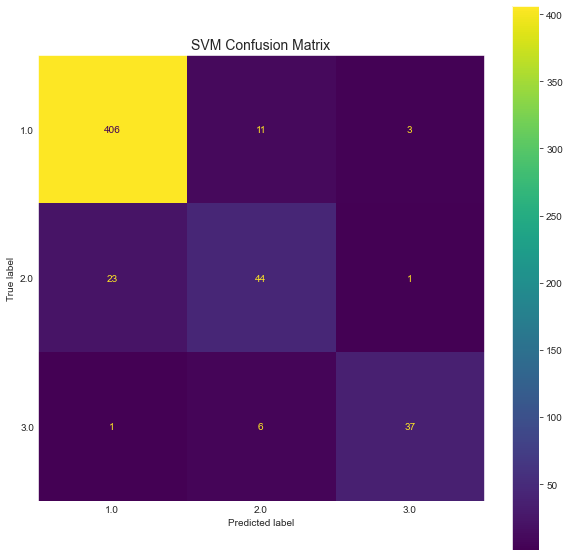

In [521]:
y_pred = clf.predict(mm_scaler.transform(X_test))

cm = confusion_matrix(y_test, y_pred, labels = clf.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = clf.classes_)

fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.title('SVM Confusion Matrix', fontsize=14)
plt.grid(False)
plt.show()

In [522]:
print(classification_report(y_test, y_pred, target_names = ['Normal', 'Suspect', 'Pathological'])) #classes coming from 1, 2, and 3

              precision    recall  f1-score   support

      Normal       0.94      0.97      0.96       420
     Suspect       0.72      0.65      0.68        68
Pathological       0.90      0.84      0.87        44

    accuracy                           0.92       532
   macro avg       0.86      0.82      0.84       532
weighted avg       0.91      0.92      0.91       532



Since the suspect records come between normal and pathological estimates, it isn't much of a surprise that the model has the hardest time classifying those records. The model does slightly better if we choose to NOT stratify on y. We wanted to do this since the classes are imbalanced. 

However, it's interesting that our results are improved overall with stratify turned off..

Since the model can classify by proximity, let's next try 

<b>K Nearest Neighbors:</b>

In [523]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [524]:
param_grid = {'n_neighbors': [1, 5, 10, 20, 50], 'weights': ['uniform', 'distance'], 'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute')}

knn = KNeighborsClassifier()

clf = GridSearchCV(knn, param_grid, cv=5, n_jobs=-1)
clf.fit(X_train, y_train)

print('GridSearch Best Estimator: {}'.format(clf.best_estimator_))
print('GridSearch Best Parameters: {}'.format(clf.best_params_))
print()
print('KNeighbors Classifier Accuracy: {:.2%}'.format(clf.score(X_test, y_test)))

GridSearch Best Estimator: KNeighborsClassifier(weights='distance')
GridSearch Best Parameters: {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'distance'}

KNeighbors Classifier Accuracy: 92.11%


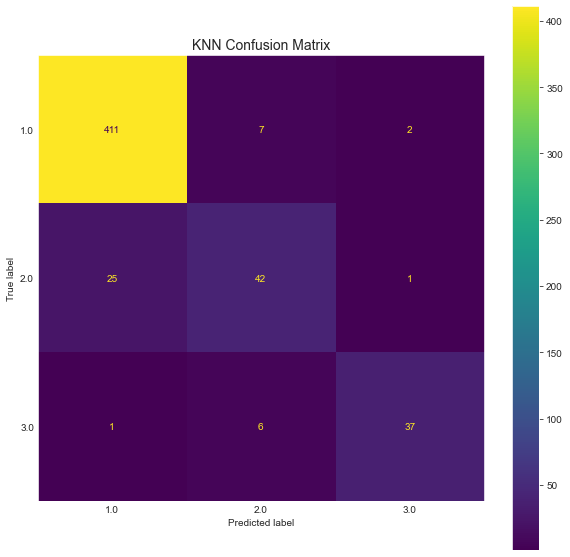

In [525]:
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels = clf.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = clf.classes_)

fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.title('KNN Confusion Matrix', fontsize=14)
plt.grid(False)
plt.show()

In [526]:
print(classification_report(y_test, y_pred, target_names = ['Normal', 'Suspect', 'Pathological']))

              precision    recall  f1-score   support

      Normal       0.94      0.98      0.96       420
     Suspect       0.76      0.62      0.68        68
Pathological       0.93      0.84      0.88        44

    accuracy                           0.92       532
   macro avg       0.88      0.81      0.84       532
weighted avg       0.92      0.92      0.92       532



It looks like the KNeighbors Classifier did a little better for normal records, but slightly worse for suspect and pathological records. 



<b>Logistic Regression:</b>

In [527]:
param_grid = {'penalty': ['l1', 'l2'], 'solver': ('newton-cg', 'lbfgs', 'liblinear'),
              'C': [1, 2, 5, 10, 20]}

logreg = LogisticRegression(max_iter=500, random_state=3, multi_class='multinomial', n_jobs=-1)

clf = GridSearchCV(logreg, param_grid, cv=5, n_jobs=-1)
clf.fit(X_train, y_train)

print('GridSearch Best Estimator: {}'.format(clf.best_estimator_))
print('GridSearch Best Parameters: {}'.format(clf.best_params_))
print()
print('Logistic Regression Accuracy: {:.2%}'.format(clf.score(X_test, y_test)))

GridSearch Best Estimator: LogisticRegression(C=1, max_iter=500, multi_class='multinomial', n_jobs=-1,
                   random_state=3, solver='newton-cg')
GridSearch Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}

Logistic Regression Accuracy: 90.60%


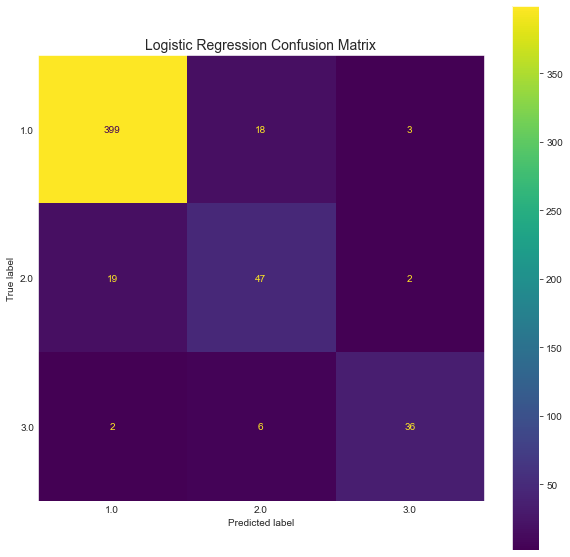

In [528]:
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels = clf.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = clf.classes_)

fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.title('Logistic Regression Confusion Matrix', fontsize=14)
plt.grid(False)
plt.show()

In [529]:
print(classification_report(y_test, y_pred, target_names = ['Normal', 'Suspect', 'Pathological']))

              precision    recall  f1-score   support

      Normal       0.95      0.95      0.95       420
     Suspect       0.66      0.69      0.68        68
Pathological       0.88      0.82      0.85        44

    accuracy                           0.91       532
   macro avg       0.83      0.82      0.82       532
weighted avg       0.91      0.91      0.91       532



Logistic Regression doesn't perform as well as the previous two classifier algorithms, though not by much.

### Stratified KFold w/ Random Forest & AdaBoost Classifier
Let's now try a different approach using Stratified KFold with the Random Forest Classifier

In [531]:
rf = RandomForestClassifier(n_estimators=1000)

skf_scores = []
skf_f1scores = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx] #We want to use scaled values.
    y_train, y_test = y[train_idx], y[test_idx]
    
    rf.fit(X_train, y_train)
    skf_scores.append(rf.score(X_test, y_test))
    
    y_pred = rf.predict(X_test)
    #print(classification_report(y_test, y_pred, target_names = ['Normal', 'Suspect', 'Pathological']))
    
    print('Fold {} F1 Score: {:.2%}'.format(i+1, f1_score(y_test, y_pred, average='micro'))) #micro to peform global f1 score
    skf_f1scores.append(f1_score(y_test, y_pred, average='micro'))
    
print("List of Accuracies: {}".format(skf_scores))

print()
print("Mean of Accuracies: {:.2%}".format(np.mean(skf_scores)))
print("Mean of F1 Scores: {:.2%}".format(np.mean(skf_f1scores)))

Fold 1 F1 Score: 95.31%
Fold 2 F1 Score: 92.71%
Fold 3 F1 Score: 94.35%
Fold 4 F1 Score: 95.53%
Fold 5 F1 Score: 94.12%
List of Accuracies: [0.9530516431924883, 0.9270588235294117, 0.9435294117647058, 0.9552941176470588, 0.9411764705882353]

Mean of Accuracies: 94.40%
Mean of F1 Scores: 94.40%


It looks we like we acquired some improvement with the Random Forest Classifier. Since many of our attributes contribute to being labelled as a certain class based on some combination of factors, this algorithm works well.

In [532]:
param_grid = {'n_estimators': [50, 100, 250, 500, 1000], 'criterion': ('gini', 'entropy'),
              'min_samples_leaf': [1, 2, 5, 10, 20, 50], 'min_samples_split' : [5, 10, 25, 50],
              'max_depth': [1, 3, 5, 7, 10]}

In [533]:
'''
rf = RandomForestClassifier(random_state=3, n_jobs=-1)

clf = GridSearchCV(rf, param_grid, cv=5)
clf.fit(X_train, y_train)

print('GridSearch Best Estimator: {}'.format(clf.best_estimator_))
print('GridSearch Best Parameters: {}'.format(clf.best_params_))
print()
print('Logistic Regression Accuracy: {:.2%}'.format(clf.score(X_test, y_test)))

'''

"\nrf = RandomForestClassifier(random_state=3, n_jobs=-1)\n\nclf = GridSearchCV(rf, param_grid, cv=5)\nclf.fit(X_train, y_train)\n\nprint('GridSearch Best Estimator: {}'.format(clf.best_estimator_))\nprint('GridSearch Best Parameters: {}'.format(clf.best_params_))\nprint()\nprint('Logistic Regression Accuracy: {:.2%}'.format(clf.score(X_test, y_test)))\n\n"

In [534]:
'''
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels = clf.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = clf.classes_)

fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.title('Logistic Regression Confusion Matrix', fontsize=14)
plt.grid(False)
plt.show()

'''

"\ny_pred = clf.predict(X_test)\n\ncm = confusion_matrix(y_test, y_pred, labels = clf.classes_)\ncm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = clf.classes_)\n\nfig, ax = plt.subplots(figsize=(10,10))\ncm_display.plot(ax=ax)\nplt.tick_params(axis=u'both', which=u'both',length=0)\nplt.title('Logistic Regression Confusion Matrix', fontsize=14)\nplt.grid(False)\nplt.show()\n\n"

In [535]:
'''
print(classification_report(y_test, y_pred, target_names = ['Normal', 'Suspect', 'Pathological']))
'''

"\nprint(classification_report(y_test, y_pred, target_names = ['Normal', 'Suspect', 'Pathological']))\n"

How about <b>Adaboost Classifier</b>?

In [537]:
rf = AdaBoostClassifier(n_estimators=1000)

skf_scores = []
skf_f1scores = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx] #We want to use scaled values.
    y_train, y_test = y[train_idx], y[test_idx]
    
    rf.fit(X_train, y_train)
    skf_scores.append(rf.score(X_test, y_test))
    
    y_pred = rf.predict(X_test)
    #print(classification_report(y_test, y_pred, target_names = ['Normal', 'Suspect', 'Pathological']))
    
    print('Fold {} F1 Score: {:.2%}'.format(i+1, f1_score(y_test, y_pred, average='micro'))) #micro to peform global f1 score
    skf_f1scores.append(f1_score(y_test, y_pred, average='micro'))
    
print("List of Accuracies: {}".format(skf_scores))

print()
print("Mean of Accuracies: {:.2%}".format(np.mean(skf_scores)))
print("Mean of F1 Scores: {:.2%}".format(np.mean(skf_f1scores)))

Fold 1 F1 Score: 83.57%
Fold 2 F1 Score: 87.29%
Fold 3 F1 Score: 89.41%
Fold 4 F1 Score: 70.12%
Fold 5 F1 Score: 90.82%
List of Accuracies: [0.8356807511737089, 0.8729411764705882, 0.8941176470588236, 0.7011764705882353, 0.908235294117647]

Mean of Accuracies: 84.24%
Mean of F1 Scores: 84.24%


The Random Forest Classifier out-performs the AdaBoost Classifier.

### XGBoost Classifier, CatBoost Classifier w/ Optuna

Next, we'll turn things up a notch and employ some powerful algorithms with Optuna to aid us in hyperparameter optimization. I'll begin with the XGBoost Classifier.

In [426]:
def objective(trial, X=X, y=y):
    
    X_train, X_test, y_train, y_test = train_test_split(X_all, y, random_state=3, test_size=0.25)
    
    param_grid = {
        'tree_method':'gpu_hist',  
        'reg_lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'reg_alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': 4000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
        'random_state': trial.suggest_categorical('random_state', [24, 48, 2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'gamma' : trial.suggest_int('gamma', 1, 10)
    }
    
    xgbclf = xgb.XGBClassifier(enable_categorical=True, n_jobs = -1, booster='gbtree', **param_grid)  
    
    xgbclf.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)
    
    y_pred = xgbclf.predict(X_test)
    
    f1 = f1_score(y_test, y_pred, average='micro')
    
    #return rmse 
    return f1

In [427]:
study = optuna.create_study(direction='maximize') 
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-04-18 19:14:23,521] A new study created in memory with name: no-name-c1893949-96be-426c-9b04-44529785d93b


[19:14:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:14:25,603] Trial 0 finished with value: 0.7894736842105263 and parameters: {'lambda': 1.1504599361713692, 'alpha': 0.08351934009771472, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.016, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 295, 'gamma': 1}. Best is trial 0 with value: 0.7894736842105263.


[19:14:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:14:29,720] Trial 1 finished with value: 0.881578947368421 and parameters: {'lambda': 0.008161581324865021, 'alpha': 0.09830933523247856, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.016, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 50, 'gamma': 4}. Best is trial 1 with value: 0.881578947368421.


[19:14:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:14:33,150] Trial 2 finished with value: 0.8421052631578947 and parameters: {'lambda': 0.002962128061216726, 'alpha': 0.06094097172755792, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.009, 'max_depth': 7, 'random_state': 24, 'min_child_weight': 100, 'gamma': 9}. Best is trial 1 with value: 0.881578947368421.


[19:14:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:14:36,325] Trial 3 finished with value: 0.7894736842105263 and parameters: {'lambda': 0.39888434429791525, 'alpha': 4.76923433316544, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.016, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 287, 'gamma': 10}. Best is trial 1 with value: 0.881578947368421.


[19:14:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:14:42,903] Trial 4 finished with value: 0.8571428571428571 and parameters: {'lambda': 0.008731627811947407, 'alpha': 0.06472124089467704, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.016, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 49, 'gamma': 10}. Best is trial 1 with value: 0.881578947368421.


[19:14:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:14:46,075] Trial 5 finished with value: 0.7894736842105263 and parameters: {'lambda': 0.36227020798693466, 'alpha': 0.0436908654536234, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 290, 'gamma': 7}. Best is trial 1 with value: 0.881578947368421.


[19:14:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:14:48,912] Trial 6 finished with value: 0.8552631578947367 and parameters: {'lambda': 2.89752496367093, 'alpha': 0.16715522719988649, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.009, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 169, 'gamma': 9}. Best is trial 1 with value: 0.881578947368421.


[19:14:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:14:50,990] Trial 7 finished with value: 0.7894736842105263 and parameters: {'lambda': 0.012739746213080747, 'alpha': 0.0022017214282487015, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.016, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 107, 'gamma': 4}. Best is trial 1 with value: 0.881578947368421.


[19:14:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:15:01,123] Trial 8 finished with value: 0.8796992481203008 and parameters: {'lambda': 4.358258821881139, 'alpha': 0.007816029849178207, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.018, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 55, 'gamma': 4}. Best is trial 1 with value: 0.881578947368421.


[19:15:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:15:13,265] Trial 9 finished with value: 0.924812030075188 and parameters: {'lambda': 2.532083594144472, 'alpha': 0.05228150098003049, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 16, 'gamma': 2}. Best is trial 9 with value: 0.924812030075188.


[19:15:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:15:17,625] Trial 10 finished with value: 0.7894736842105263 and parameters: {'lambda': 0.0719142772985578, 'alpha': 3.621069346721728, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 193, 'gamma': 1}. Best is trial 9 with value: 0.924812030075188.


[19:15:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:15:22,660] Trial 11 finished with value: 0.9323308270676691 and parameters: {'lambda': 0.001156984458220063, 'alpha': 0.4963522434632126, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 8, 'gamma': 3}. Best is trial 11 with value: 0.9323308270676691.


[19:15:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:15:26,330] Trial 12 finished with value: 0.9285714285714286 and parameters: {'lambda': 0.05980482601146858, 'alpha': 0.6974422554739766, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 17, 'gamma': 2}. Best is trial 11 with value: 0.9323308270676691.


[19:15:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:15:29,980] Trial 13 finished with value: 0.943609022556391 and parameters: {'lambda': 0.042447334792008684, 'alpha': 0.6887086857977741, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 1, 'gamma': 3}. Best is trial 13 with value: 0.943609022556391.


[19:15:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:15:54,685] Trial 14 finished with value: 0.9304511278195489 and parameters: {'lambda': 0.0018395126647774468, 'alpha': 0.6762514326536233, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 4, 'gamma': 6}. Best is trial 13 with value: 0.943609022556391.


[19:15:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:16:05,660] Trial 15 finished with value: 0.8590225563909775 and parameters: {'lambda': 0.027385931458099318, 'alpha': 0.8826405243146916, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.012, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 106, 'gamma': 3}. Best is trial 13 with value: 0.943609022556391.


[19:16:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:16:08,190] Trial 16 finished with value: 0.7894736842105263 and parameters: {'lambda': 0.001574134213601919, 'alpha': 1.5046433258508811, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 238, 'gamma': 6}. Best is trial 13 with value: 0.943609022556391.


[19:16:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:16:13,780] Trial 17 finished with value: 0.8552631578947367 and parameters: {'lambda': 0.225980967387024, 'alpha': 9.950301727192889, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 75, 'gamma': 3}. Best is trial 13 with value: 0.943609022556391.


[19:16:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:16:34,173] Trial 18 finished with value: 0.8590225563909775 and parameters: {'lambda': 0.0038877604733065954, 'alpha': 0.2562066522889665, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 141, 'gamma': 5}. Best is trial 13 with value: 0.943609022556391.


[19:16:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:16:38,855] Trial 19 finished with value: 0.9285714285714286 and parameters: {'lambda': 9.105349002220564, 'alpha': 0.017763992946490358, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 7, 'gamma': 3}. Best is trial 13 with value: 0.943609022556391.


[19:16:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:16:45,300] Trial 20 finished with value: 0.8533834586466166 and parameters: {'lambda': 0.001035556697383765, 'alpha': 0.32344138789568144, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.012, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 73, 'gamma': 5}. Best is trial 13 with value: 0.943609022556391.


[19:16:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:17:04,804] Trial 21 finished with value: 0.9229323308270677 and parameters: {'lambda': 0.003112834582438267, 'alpha': 0.5338578427054873, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 5, 'gamma': 7}. Best is trial 13 with value: 0.943609022556391.


[19:17:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:17:28,025] Trial 22 finished with value: 0.9078947368421053 and parameters: {'lambda': 0.01955604519441019, 'alpha': 1.8807461020336587, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 31, 'gamma': 6}. Best is trial 13 with value: 0.943609022556391.


[19:17:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:17:33,520] Trial 23 finished with value: 0.9022556390977443 and parameters: {'lambda': 0.005338537754828169, 'alpha': 1.2085506000154458, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 44, 'gamma': 7}. Best is trial 13 with value: 0.943609022556391.


[19:17:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:18:27,445] Trial 24 finished with value: 0.8571428571428571 and parameters: {'lambda': 0.0014585710721931504, 'alpha': 0.4427353822394629, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 81, 'gamma': 2}. Best is trial 13 with value: 0.943609022556391.


[19:18:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:18:36,090] Trial 25 finished with value: 0.9229323308270677 and parameters: {'lambda': 0.03659192874609762, 'alpha': 2.8556385911800746, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 1, 'gamma': 5}. Best is trial 13 with value: 0.943609022556391.


[19:18:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:18:41,548] Trial 26 finished with value: 0.9041353383458647 and parameters: {'lambda': 0.0021708915841225623, 'alpha': 0.24385147346480868, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.018, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 33, 'gamma': 8}. Best is trial 13 with value: 0.943609022556391.


[19:18:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:18:58,563] Trial 27 finished with value: 0.8552631578947367 and parameters: {'lambda': 0.006546630751462982, 'alpha': 7.177906744078438, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 124, 'gamma': 4}. Best is trial 13 with value: 0.943609022556391.


[19:18:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:19:02,030] Trial 28 finished with value: 0.9172932330827067 and parameters: {'lambda': 0.18366224242351833, 'alpha': 1.982587575888174, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 28, 'gamma': 6}. Best is trial 13 with value: 0.943609022556391.


[19:19:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:19:10,189] Trial 29 finished with value: 0.8552631578947367 and parameters: {'lambda': 1.006738392148305, 'alpha': 0.15164102443111652, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 61, 'gamma': 3}. Best is trial 13 with value: 0.943609022556391.


[19:19:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:19:12,330] Trial 30 finished with value: 0.7894736842105263 and parameters: {'lambda': 0.014674242397592506, 'alpha': 0.9541391835111034, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 226, 'gamma': 1}. Best is trial 13 with value: 0.943609022556391.


[19:19:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:19:16,042] Trial 31 finished with value: 0.9454887218045114 and parameters: {'lambda': 0.742890593696788, 'alpha': 0.028877696065708648, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 1, 'gamma': 3}. Best is trial 31 with value: 0.9454887218045114.


[19:19:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:19:21,430] Trial 32 finished with value: 0.9454887218045114 and parameters: {'lambda': 0.7241848293800969, 'alpha': 0.027751563895336794, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 1, 'gamma': 2}. Best is trial 31 with value: 0.9454887218045114.


[19:19:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:19:31,269] Trial 33 finished with value: 0.9172932330827067 and parameters: {'lambda': 0.8083348399985201, 'alpha': 0.018905503510630767, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 26, 'gamma': 2}. Best is trial 31 with value: 0.9454887218045114.


[19:19:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:19:40,263] Trial 34 finished with value: 0.9116541353383458 and parameters: {'lambda': 0.5690948442563952, 'alpha': 0.023859485443632505, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 43, 'gamma': 1}. Best is trial 31 with value: 0.9454887218045114.


[19:19:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:19:48,035] Trial 35 finished with value: 0.8590225563909775 and parameters: {'lambda': 1.4654084373705285, 'alpha': 0.007578310167077503, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.014, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 84, 'gamma': 4}. Best is trial 31 with value: 0.9454887218045114.


[19:19:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:19:54,590] Trial 36 finished with value: 0.9154135338345863 and parameters: {'lambda': 0.12591583336257078, 'alpha': 0.101371855811829, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 23, 'gamma': 3}. Best is trial 31 with value: 0.9454887218045114.


[19:19:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:20:02,791] Trial 37 finished with value: 0.8909774436090225 and parameters: {'lambda': 0.48080530677275274, 'alpha': 0.03150138004864142, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 60, 'gamma': 2}. Best is trial 31 with value: 0.9454887218045114.


[19:20:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:20:09,825] Trial 38 finished with value: 0.9078947368421053 and parameters: {'lambda': 1.6627282321128167, 'alpha': 0.010411307034852171, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.016, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 43, 'gamma': 1}. Best is trial 31 with value: 0.9454887218045114.


[19:20:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:20:20,710] Trial 39 finished with value: 0.9454887218045114 and parameters: {'lambda': 0.26851675795238894, 'alpha': 0.0016523114859109032, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.009, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 2, 'gamma': 3}. Best is trial 31 with value: 0.9454887218045114.


[19:20:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:20:23,682] Trial 40 finished with value: 0.7894736842105263 and parameters: {'lambda': 0.24323378815407856, 'alpha': 0.005642838774989445, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.009, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 262, 'gamma': 4}. Best is trial 31 with value: 0.9454887218045114.


[19:20:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:20:31,295] Trial 41 finished with value: 0.9191729323308271 and parameters: {'lambda': 0.3370820621836757, 'alpha': 0.0010043510658757867, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.009, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 14, 'gamma': 3}. Best is trial 31 with value: 0.9454887218045114.


[19:20:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:20:41,870] Trial 42 finished with value: 0.8872180451127819 and parameters: {'lambda': 0.0974415012165537, 'alpha': 0.003395685038562076, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.009, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 35, 'gamma': 2}. Best is trial 31 with value: 0.9454887218045114.


[19:20:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:20:49,685] Trial 43 finished with value: 0.9191729323308271 and parameters: {'lambda': 0.7125114060138851, 'alpha': 0.08885024888218655, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.01, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 18, 'gamma': 3}. Best is trial 31 with value: 0.9454887218045114.


[19:20:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:20:58,270] Trial 44 finished with value: 0.9342105263157895 and parameters: {'lambda': 4.567311086820938, 'alpha': 0.013160603331457554, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 3, 'gamma': 4}. Best is trial 31 with value: 0.9454887218045114.


[19:20:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:21:06,852] Trial 45 finished with value: 0.9266917293233082 and parameters: {'lambda': 5.715602166177979, 'alpha': 0.001638150335055283, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 1, 'gamma': 4}. Best is trial 31 with value: 0.9454887218045114.


[19:21:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:21:10,269] Trial 46 finished with value: 0.7894736842105263 and parameters: {'lambda': 2.9572781069683294, 'alpha': 0.012221630648522518, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 182, 'gamma': 2}. Best is trial 31 with value: 0.9454887218045114.


[19:21:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:21:17,534] Trial 47 finished with value: 0.8571428571428571 and parameters: {'lambda': 0.0489411698054238, 'alpha': 0.0389564941888556, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 55, 'gamma': 4}. Best is trial 31 with value: 0.9454887218045114.


[19:21:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:21:24,710] Trial 48 finished with value: 0.8609022556390977 and parameters: {'lambda': 2.102885699783991, 'alpha': 0.004099038300501052, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.009, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 93, 'gamma': 5}. Best is trial 31 with value: 0.9454887218045114.


[19:21:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-18 19:21:27,079] Trial 49 finished with value: 0.9360902255639098 and parameters: {'lambda': 0.13618593851668653, 'alpha': 0.0516669926982333, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.016, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 17, 'gamma': 2}. Best is trial 31 with value: 0.9454887218045114.


Number of finished trials: 50
Best trial: {'lambda': 0.742890593696788, 'alpha': 0.028877696065708648, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 1, 'gamma': 3}


In [428]:
optuna.visualization.plot_optimization_history(study)

In [429]:
best_args = study.best_params 
best_args

{'lambda': 0.742890593696788,
 'alpha': 0.028877696065708648,
 'colsample_bytree': 0.4,
 'subsample': 0.6,
 'learning_rate': 0.02,
 'max_depth': 9,
 'random_state': 2020,
 'min_child_weight': 1,
 'gamma': 3}

In [452]:
xgbclf = xgb.XGBClassifier(n_jobs = -1, booster='gbtree', **best_args)  
    
xgbclf.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)
    
y_pred = xgbclf.predict(X_test)
    
f1 = f1_score(y_test, y_pred, average='micro')

print()
print('XGBoost Classifier Optuna F1-Score: {:.2%}'.format(f1))

[20:22:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "l2_leaf_reg", "min_child_samples" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:22:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

XGBoost Classifier Optuna F1-Score: 92.24%


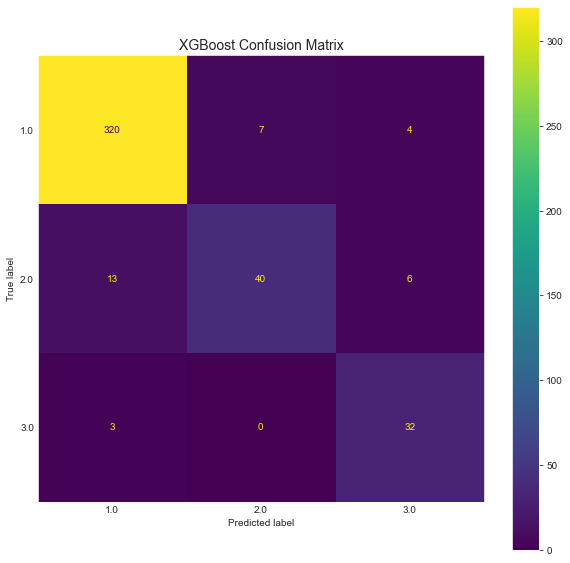

In [453]:
cm = confusion_matrix(y_test, y_pred, labels = clf.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = clf.classes_)

fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.title('XGBoost Confusion Matrix', fontsize=14)
plt.grid(False)
plt.show()

In [454]:
print(classification_report(y_test, y_pred, target_names = ['Normal', 'Suspect', 'Pathological']))

              precision    recall  f1-score   support

      Normal       0.95      0.97      0.96       331
     Suspect       0.85      0.68      0.75        59
Pathological       0.76      0.91      0.83        35

    accuracy                           0.92       425
   macro avg       0.86      0.85      0.85       425
weighted avg       0.92      0.92      0.92       425



It seems we can't use categorical data with the tree method used. Lets now try CatBoost Classifier

In [540]:
def objective(trial, X=X, y=y):
    
    X_train, X_test, y_train, y_test = train_test_split(X_all, y, random_state=3, test_size=0.25) #Still does better with no stratify
    
    param_grid = {
        'l2_leaf_reg' : trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5),
        'min_child_samples' : trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32]),
        #'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': 2000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,16]),
        'random_state': trial.suggest_categorical('random_state', [24, 48, 2020]),
        'grow_policy' : 'Depthwise',
        'use_best_model' : True,
        'od_type' : 'iter', 
        'od_wait' : 20
    }
    
    clf = CatBoostClassifier(**param_grid)  
    
    clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)
    
    y_pred = clf.predict(X_test)
    
    f1 = f1_score(y_test, y_pred, average='micro')
    
    #return rmse 
    return f1

In [541]:
study = optuna.create_study(direction='maximize') 
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-04-19 10:03:00,566] A new study created in memory with name: no-name-940d1a3b-7ed3-4a00-864b-f58711df9eba
[I 2022-04-19 10:03:27,863] Trial 0 finished with value: 0.9605263157894737 and parameters: {'l2_leaf_reg': 2.0, 'min_child_samples': 8, 'learning_rate': 0.009, 'max_depth': 16, 'random_state': 2020}. Best is trial 0 with value: 0.9605263157894737.
[I 2022-04-19 10:03:51,867] Trial 1 finished with value: 0.9548872180451128 and parameters: {'l2_leaf_reg': 4.0, 'min_child_samples': 8, 'learning_rate': 0.008, 'max_depth': 13, 'random_state': 24}. Best is trial 0 with value: 0.9605263157894737.
[I 2022-04-19 10:04:06,962] Trial 2 finished with value: 0.9530075187969925 and parameters: {'l2_leaf_reg': 5.5, 'min_child_samples': 4, 'learning_rate': 0.012, 'max_depth': 9, 'random_state': 24}. Best is trial 0 with value: 0.9605263157894737.
[I 2022-04-19 10:04:09,143] Trial 3 finished with value: 0.9530075187969925 and parameters: {'l2_leaf_reg': 1.5, 'min_child_samples': 32, 'learn

[I 2022-04-19 10:15:30,073] Trial 31 finished with value: 0.9605263157894737 and parameters: {'l2_leaf_reg': 2.0, 'min_child_samples': 8, 'learning_rate': 0.009, 'max_depth': 16, 'random_state': 24}. Best is trial 0 with value: 0.9605263157894737.
[I 2022-04-19 10:15:58,867] Trial 32 finished with value: 0.9605263157894737 and parameters: {'l2_leaf_reg': 2.0, 'min_child_samples': 8, 'learning_rate': 0.009, 'max_depth': 16, 'random_state': 24}. Best is trial 0 with value: 0.9605263157894737.
[I 2022-04-19 10:16:41,037] Trial 33 finished with value: 0.9586466165413534 and parameters: {'l2_leaf_reg': 5.5, 'min_child_samples': 8, 'learning_rate': 0.009, 'max_depth': 16, 'random_state': 24}. Best is trial 0 with value: 0.9605263157894737.
[I 2022-04-19 10:16:52,882] Trial 34 finished with value: 0.956766917293233 and parameters: {'l2_leaf_reg': 2.5, 'min_child_samples': 32, 'learning_rate': 0.009, 'max_depth': 16, 'random_state': 24}. Best is trial 0 with value: 0.9605263157894737.
[I 2022-

Number of finished trials: 50
Best trial: {'l2_leaf_reg': 2.0, 'min_child_samples': 8, 'learning_rate': 0.009, 'max_depth': 16, 'random_state': 2020}


In [542]:
optuna.visualization.plot_optimization_history(study) 

In [547]:
best_args = {'l2_leaf_reg': 1.5,
 'min_child_samples': 8,
 'learning_rate': 0.01,
 'max_depth': 15,
 'random_state': 48}
best_args

{'l2_leaf_reg': 1.5,
 'min_child_samples': 8,
 'learning_rate': 0.01,
 'max_depth': 15,
 'random_state': 48}

After iterating through some different combinations of parameters, this set of parameters yeilds the best results for this
algorithm/model.

In [546]:
clf = CatBoostClassifier(n_estimators = 2000, grow_policy = 'Depthwise', use_best_model = True, od_type = 'iter', od_wait = 20, **best_args)  
    
clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)
    
y_pred = clf.predict(X_test)
    
f1 = f1_score(y_test, y_pred, average='micro')
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
acc = accuracy_score(y_test, y_pred)

print()
print('CatBoost Classifier Optuna F1-Score: {:.2%}'.format(f1))
print('CatBoost Classifier Optuna Precision Score: {:.2%}'.format(precision))
print('CatBoost Classifier Optuna Recall Score: {:.2%}'.format(recall))
print('CatBoost Classifier Optuna Accuracy Score: {:.2%}'.format(acc))


CatBoost Classifier Optuna F1-Score: 95.06%
CatBoost Classifier Optuna Precision Score: 95.06%
CatBoost Classifier Optuna Recall Score: 95.06%
CatBoost Classifier Optuna Accuracy Score: 95.06%


Using the same parameters returned from the best model from Optuna, we ended up with our highest F1 Score of 95.06, higher than what we got for the XGBoost Classifier. I'll also print the other overall metrics.

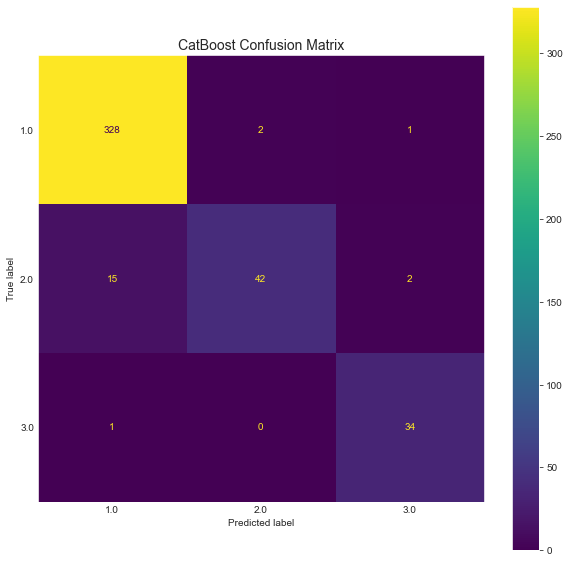

In [548]:
cm = confusion_matrix(y_test, y_pred, labels = clf.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = clf.classes_)

fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.title('CatBoost Confusion Matrix', fontsize=14)
plt.grid(False)
plt.show()

In [549]:
print(classification_report(y_test, y_pred, target_names = ['Normal', 'Suspect', 'Pathological']))

              precision    recall  f1-score   support

      Normal       0.95      0.99      0.97       331
     Suspect       0.95      0.71      0.82        59
Pathological       0.92      0.97      0.94        35

    accuracy                           0.95       425
   macro avg       0.94      0.89      0.91       425
weighted avg       0.95      0.95      0.95       425



This final model classifies the unseen test data very well. Of course the weakest category is still the suspect records. Aside from just a couple incorrectly identified records, we had 15 records predicted to be normal but were actually suspect (<b>false negatives</b>). These types of records I believe are the most difficult to distinguish since some records could be more on the side of the spectrum of normal than pathological. 

Looking at our classification report, our lowest metric by far was the recall score for suspect records.

<b>Recall Formula: TP / (TP + FN) </b>

We can see that what drives this score down are those 15 false negatives for suspect records. This recall score for suspect records is also the highest across all models we have attempted here. Therefore, in comparison to the other algorithms used, we have arrived at a conclusive model.

### Exporting Model to Pickle

In [1]:
import joblib 
import pickle

joblib.dump(study, 'study.dump')

NameError: name 'study' is not defined

In [551]:
pickl = {'model' : clf}
pickle.dump(pickl, open('model_file'+'.p', 'wb'))

In [552]:
file_name = 'model_file.p'
with open(file_name, 'rb') as pickled:
    data = pickle.load(pickled)
    model = data['model']

In [553]:
model.predict(X_test[1, :].reshape(1, -1))

array([[1.]])

In [554]:
X_test[1, :]

array([ 0.07075681, -0.04612774, -0.20320955,  1.23365708,  0.37524298,
       -0.0574756 , -0.2687543 , -1.80292846,  1.20857852, -0.53536128,
        2.63241051,  1.1953335 , -1.37309701,  0.33303304,  2.35080404,
       -0.45844382, -0.02760033, -0.03916222, -0.07538522, -0.2004807 ,
        1.11298001])

In [555]:
print(list(pd.Series(X_test[1, :])))

[0.07075681236111234, -0.046127744164425076, -0.20320955423320786, 1.2336570841235197, 0.375242980801288, -0.05747560370484534, -0.2687543030278473, -1.8029284641019496, 1.20857852411365, -0.5353612763559414, 2.6324105081226428, 1.1953334999796668, -1.3730970077141795, 0.33303303774971904, 2.3508040350104698, -0.45844381526053474, -0.0276003259454858, -0.03916222043397965, -0.07538521806785393, -0.20048070027205386, 1.1129800127196288]
